#### Install necessary libraries

In [ ]:
%pip install git+https://github.com/facebookresearch/segment-anything.git
%pip install opencv-python mediapipe ultralytics numpy torch matplotlib

<br><br>

####  Import Libraries

In [1]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

C:\Users\sirom\AppData\Roaming\Python\Python310\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


<br><br>

#### Load Models

Download SAM model from: https://huggingface.co/datasets/Gourieff/ReActor/blob/main/models/sams/sam_vit_b_01ec64.pth

In [2]:
# Load YOLO model
model = YOLO("yolov8n.pt")  # you can use custom model 
 
# Load SAM model
sam_checkpoint = r"C:\Users\sirom\Desktop\gis-ai\sam\pretrained-sam-models\sam_vit_b_01ec64.pth"  # Replace with your model path
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam) 

100%|██████████| 6.25M/6.25M [00:01<00:00, 6.22MB/s]


cuda


<br>

####  Detection + Segmentation

0: 448x640 1 sports ball, 48.0ms
Speed: 6.9ms preprocess, 48.0ms inference, 5.8ms postprocess per image at shape (1, 3, 448, 640)


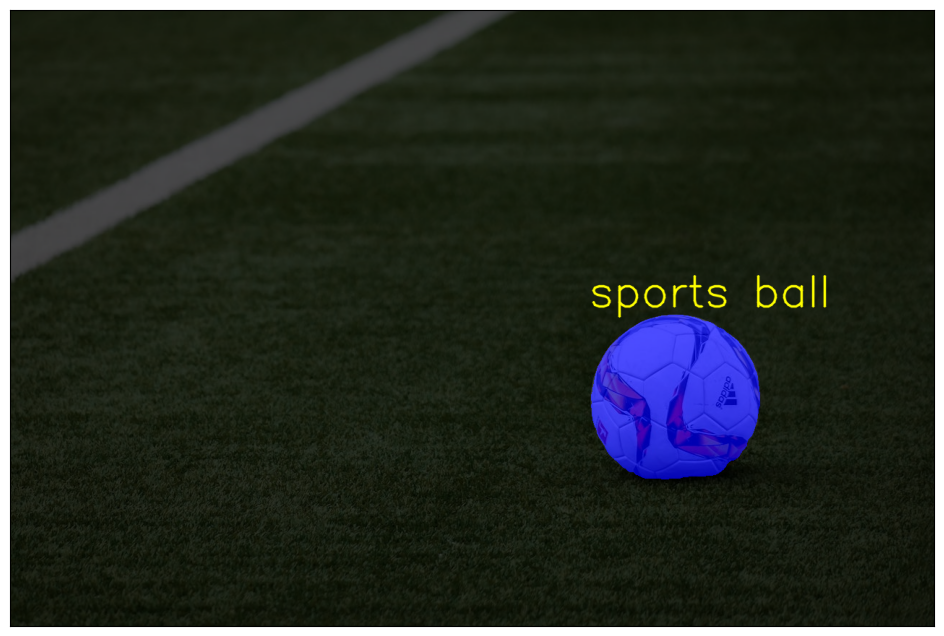

In [5]:
# Load image
image_path = r"images/ball.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for SAM

# Run YOLO inference
results = model(image, conf=0.6)

# Loop through detections
for result in results:
    # Get bounding boxes
    for box, cls in zip(result.boxes.xyxy, result.boxes.cls):   
        x1, y1, x2, y2 = map(int, box)  # Convert to integers
        
        # get ID
        class_id = int(cls)  # Class ID
        # Get class label
        class_label = model.names[class_id]   
        # Prepare SAM
        predictor.set_image(image_rgb)

        # Define a box prompt for SAM
        input_box = np.array([[x1, y1, x2, y2]])

        # Get SAM mask
        masks, _, _ = predictor.predict(box=input_box, multimask_output=False)

        # Create a copy of the original image for overlaying the mask
        highlighted_image = image_rgb.copy()

        # Apply the mask with semi-transparent blue color to the image
        mask = masks[0]
        # Create a blank image
        blue_overlay = np.zeros_like(image_rgb, dtype=np.uint8)  
        # Blue color for the segmented area (RGB)
        blue_overlay[mask == 1] = [0, 0, 255]   

        # Blend the blue overlay with the original image using transparency
        alpha = 0.7  # Transparency level for the overlay
        highlighted_image = cv2.addWeighted(highlighted_image, 1 - alpha, blue_overlay, alpha, 0)

         # Add label (class name) on top of the bounding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        label = f"{class_label}"  # Label is the class name
        cv2.putText(highlighted_image, label, (x1, y1 - 10), font, 2, (255, 255, 0), 2, cv2.LINE_AA)   

        # Optional: Save the image with the bounding box and highlighted segment
        output_filename = f"highlighted_output.png"
        cv2.imwrite(output_filename, cv2.cvtColor(highlighted_image, cv2.COLOR_RGB2BGR))

# Display the image using OpenCV
plt.figure(figsize=(15, 8))
plt.xticks([]), plt.yticks([])
plt.imshow(highlighted_image)